In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json, pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# dataset path
dataset_path = '/content/drive/My Drive/Colab Notebooks/'
path = '/content/drive/My Drive/Colab Notebooks/'

In [74]:
!pip install tensorflow==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [76]:
print(tf.keras.__version__)

2.11.0


In [77]:
data = pd.read_csv(dataset_path+'article_test.csv',encoding='utf-8')
print(f'Total number of Documents: {len(data)}')
print(data)

Total number of Documents: 18
                                                 Text       Category
0   বাংলাদেশের রাজনীতিবিদদের সহিংস, লোভী, জঘন্য, ন...       politics
1   এই প্রতিবেদনে ভবন ধসের কারণ হিসাবে নয়টি বিষয়কে...      politics 
2   গতকাল রোববার নৌ নিরাপত্তা সপ্তাহের শুরুর দিনেই...       politics
3   আমাদের মহান ভাষা আন্দোলন থেকে শুরু করে ১৯৬২ স...       politics
4   চট্টগ্রাম, মার্চ ১৫ (বিডিনিউজ টোয়েন্টিফোর ডটকম...       business
5   ৪৮ বছর ধরে বাংলাদেশের ঘরে ঘরে সমাদৃত মিল্ক ভিট...       business
6   বাংলাদেশ পাবলিক সার্ভিস কমিশনের (পিএসসি) দায়ি...       politics
7   ঢাকা, ফেব্র“য়ারি ২৮ (বিডিনিউজ টোয়েন্টিফোর ডটকম...         sports
8   কয়েক দিন আগে দুর্নীতি দমন কমিশনের একজন দায়িত্ব...       politics
9   দিনে অন্তত একবার হলেও লগ-ইন করা হয় ফেইসবুকে, ত...           tech
10  রোজা রাখার উদ্দেশ্যে শেষ রাতে উষা উদয়ের আগে য...       religion
11  বাঁশের বেষ্টনির ভেতরে পোড়া বইয়ের কালো অঙ্গার থ...     literature
12  কিশোরগঞ্জ, মে ৬ (বিডিনিউজ টোয়েন্টিফোর ডটকম)- দ...       politics
13  

In [78]:
data = data[['Text','Category']]

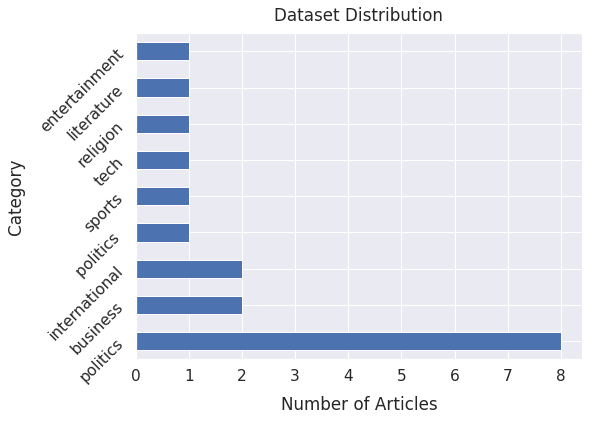

In [79]:
sns.set(font_scale=1.4)
data['Category'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number of Articles", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [80]:
def cleaning_documents(articles):
      '''
      This function will clean the news articles by removing punctuation marks and stopwords.

      Args:
      articles: a news text(str)

      returns:
      news: clean text (str)
      '''
      news = articles.replace('\n',' ')
      news = re.sub('[^\u0980-\u09FF]',' ',str(news)) #removing unnecessary punctuation
      # stopwords removal
      stp = open(path+'bangla_stopwords.txt','r',encoding='utf-8').read().split()
      result = news.split()
      news = [word.strip() for word in result if word not in stp ]
      news =" ".join(news)
      return news

In [81]:
data['cleaned'] = data['Text'].apply(cleaning_documents)  

In [82]:
sample_data = [4,5]
for i in sample_data:
  print('Original:\n',data.Text[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Category:-- ',data.Category[i],'\n')  

Original:
 চট্টগ্রাম, মার্চ ১৫ (বিডিনিউজ টোয়েন্টিফোর ডটকম)- দেশের অর্থনীতি স্থিতিশীল রয়েছে বলে দাবি করেছেন অর্থ উপদেষ্টা এবি মির্জ্জা আজিজুল ইসলাম। তিনি বলেন, "মধ্যবর্তী সূচকগুলোর অগ্রগতি, ঋণ প্রবাহ, আমদানি ও রপ্তানি হার, আয়, মজুরি ও শ্রম সরবরাহ বৃদ্ধির পরিসংখ্যানগুলো বিবেচনা এনে বলা যায় দেশে অর্থনৈতিক স্থিতিশীলতা বিরাজ করছে।" শনিবার চট্টগ্রাম সার্কিট হাউজে প্রাক বাজেট আলোচনা সভা শেষে সাংবাদিকরা সাবেক উপদেষ্টা ও রেগুলেটরি রিফর্মস কমিশনের চেয়ারম্যান আকবর আলি খানের মন্তব্য সম্পর্কে দৃষ্টি আকর্ষণ করলে অর্থ উপদেষ্টা এ কথা বলেন। 'দেশে নিরব দুর্ভিক্ষ চলছে'- শুক্রবার জাতীয় প্রেসক্লাবে এক গোলটেবিল বৈঠকে আকবর আলি খানের এই মন্ত্যবের সঙ্গে দ্বিমত প্রকাশ করে বিভিন্ন অঞ্চলের উপর পরিচালিত বিভিন্ন সংস্থার জরিপ উল্লেখ করে তিনি বলেন, "দেশে মজুরি বৃদ্ধি পেয়েছে ১৭ দশমিক ৫ শতাংশ। সে পরিমাণ মুদ্রাস্ফীতি ঘটেনি। তাহলে অবস্থা এতটা খারাপ হল কিভাবে?" অর্থ উপদেষ্টা বলেন, ওই মন্তব্য তার (আকবর আলি খান) নিজের ব্যক্তিগত মতামত। অপর এক প্রশ্নের জবাবে তিনি বলেন, আগামী বছরের বাজেট প্রণয়নের ক্ষেত্রে দেশে সা 
Cleaned:
 চট

In [83]:
# Stopwords pickle 
stp = open(path+'bangla_stopwords.txt','r',encoding='utf-8').read().split()
# open a file, where you ant to store the data
file = open(path+'bangla_stopwords.pkl', 'wb')
# dump information to that file
pickle.dump(stp, file)

In [86]:
stp = open(path+'bangla_stopwords.pkl','rb')
stp = pickle.load(stp)
len(stp)

398

In [87]:
data['Length'] = data.cleaned.apply(lambda x:len(x.split()))

# Remove the Documents with least words
dataset = data.loc[data.Length>20]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Documents".format(len(data)-len(dataset)),
      "\nTotal Remaining Documents:",len(dataset))

After Cleaning: 
Removed 0 Small Documents 
Total Remaining Documents: 18


In [88]:
dataset.to_csv(dataset_path+'cleaned_news.csv')

In [89]:
dataset = pd.read_csv(dataset_path+'cleaned_news.csv')
dataset.columns

Index(['Unnamed: 0', 'Text', 'Category', 'cleaned', 'Length'], dtype='object')

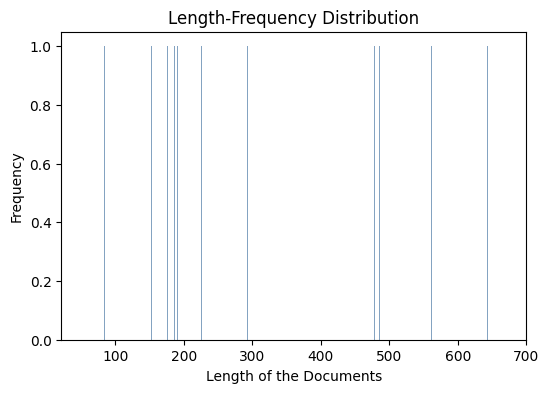

Maximum Length of a Document: 737
Minimum Length of a Document: 84
Average Length of a Document: 322.0


In [90]:
import matplotlib
matplotlib.rc_file_defaults()
frequency = dict()
for i in dataset.Length:
    frequency[i] = frequency.get(i, 0)+1

plt.figure(figsize = (6,4))
plt.bar(frequency.keys(), frequency.values(), color=(0.2, 0.4, 0.6, 0.6))
plt.xlim(21, 700)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Documents')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
#plt.savefig(path+'len_dist.png',dpi = 1000,bbox_inches ='tight')
plt.show()  
print(f"Maximum Length of a Document: {max(dataset.Length)}")
print(f"Minimum Length of a Document: {min(dataset.Length)}")
print(f"Average Length of a Document: {round(np.mean(dataset.Length),0)}")

In [91]:
def data_summary(dataset):
  '''
  This function will print the summary of the dataset

  Args:
  dataset: cleaned texts

  returns:
  documents: Number of document per class
  words: Number of words per class
  u_words: Number of unique words per class
  class_label: name of the categories
  '''
  documents = []
  words = []
  u_words = []
  #total_u_word = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
  # find class names
  class_label = [k for k,v in dataset.Category.value_counts().to_dict().items()]
  for label in class_label: 
    word_list = [word.strip().lower() for t in list(dataset[dataset.Category==label].cleaned) for word in t.strip().split()]
    counts = dict()
    for word in word_list:
      counts[word] = counts.get(word, 0)+1
    # sort the dictionary of word list  
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Documents per class
    documents.append(len(list(dataset[dataset.Category==label].cleaned)))
    # Total Word per class
    words.append(len(word_list))
    # Unique words per class 
    u_words.append(len(np.unique(word_list)))
       
    print("\nClass Name : ",label)
    print("Number of Documents:{}".format(len(list(dataset[dataset.Category==label].cleaned))))  
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Most Frequent Words:\n")
    for k,v in ordered[:10]:
      print("{}\t{}".format(k,v))
  return documents,words,u_words,class_label

# pass the whole dataset into the function

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  politics
Number of Documents:8
Number of Words:2092
Number of Unique Words:1354
Most Frequent Words:

নির্বাচন	23
দল	12
বাংলাদেশের	10
এসব	10
আওয়ামী	10
রাজনৈতিক	10
একজন	9
কথা	9
বিএনপির	9
এক	8

Class Name :  business
Number of Documents:2
Number of Words:679
Number of Unique Words:463
Most Frequent Words:

দুধ	22
মিল্ক	21
লাখ	14
ভিটার	13
ক্ষতি	10
টাকা	10
সরবরাহ	7
দেশে	7
ভিটা	7
মজুরি	5

Class Name :  international
Number of Documents:2
Number of Words:339
Number of Unique Words:254
Most Frequent Words:

সংখ্যা	7
হিমবাহের	6
গলে	5
বরফ	5
হয়েছে	5
ভূমিকম্পে	5
পানি	4
তথ্য	4
শিমিট	4
মৃতের	4

Class Name :  politics 
Number of Documents:1
Number of Words:478
Number of Unique Words:313
Most Frequent Words:

ভবন	15
হয়েছে	10
কারখানা	10
রানা	9
মালিক	9
ভবনে	7
ধসের	6
পোশাক	5
প্রতিবেদনে	4
তলা	4

Class Name :  sports
Number of Documents:1
Number of Words:293
Number of Unique Words:202
Most Frequent Words:

বরিশাল	6
সংবাদ	5
গভর্নিং	5
বিপিএল	4
ম্যাচ	4
সোমবার	4
সিদ্ধান্ত	4
আলমগীর	4
সভাপতি	4
চ

In [92]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data_matrix

,Total Documents,Total Words,Unique Words,Class Names
0,8,2092,1354,politics
1,2,679,463,business
2,2,339,254,international
3,1,478,313,politics
4,1,293,202,sports
5,1,486,361,tech
6,1,510,315,religion
7,1,737,499,literature
8,1,180,133,entertainment


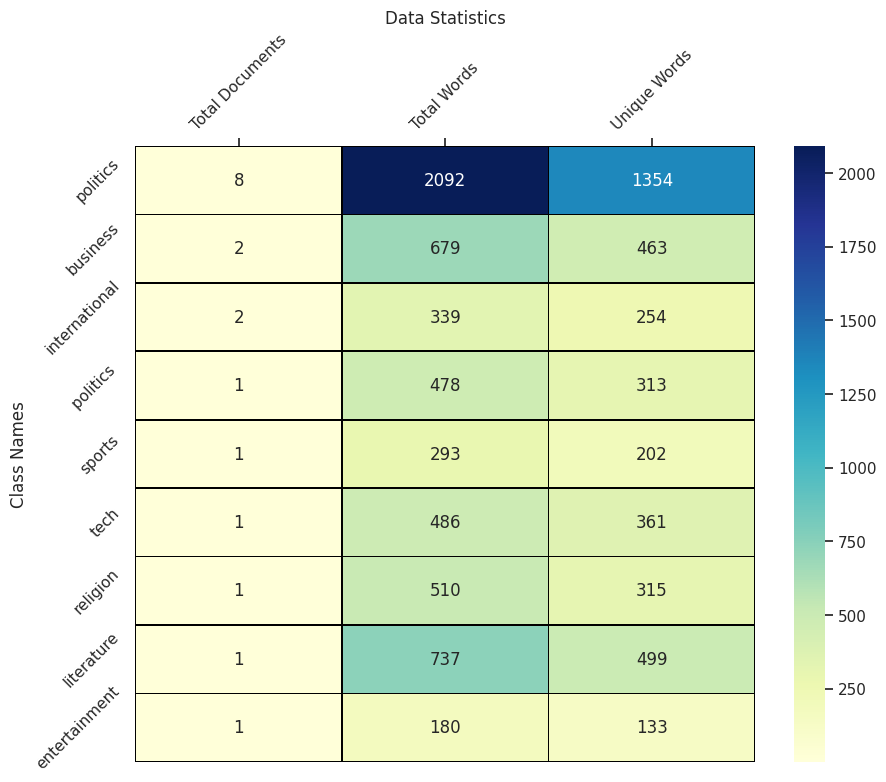

In [93]:
sns.set()
plt.figure(figsize =(10, 8))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)
# labels, title and ticks
ax.set_ylabel('Class Names') 
ax.set_title('Data Statistics')
y_label = ["Total Documents", "Total Words", "Unique Words"] 
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()

In [94]:
def label_encoding(dataset,bool):
  '''
  This function will convert categorical class names into a numeric label

  Args:
  dataset: A dataset
  bool : a boolean (True or False)

  returns:
  labels: encoded labels 
  '''
  le = LabelEncoder()
  le.fit(dataset.Category)
  encoded_labels = le.transform(dataset.Category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print(color.BOLD+"\n\t\t\t===== Label Encoding ====="+color.END,"\nClass Names:-->",le.classes_)
  return labels  

                   #===========================================================
                   ################# Dataset Splitting Function ###############
                   #=========================================================== 

def dataset_split(news,category):
  '''
  This function will split the dataset into Train-Test-Validation set

  Args:
  news: encoded texts
  category: class names

  returns:
  X_train: Encoded Training News  
  X_valid: Encoded Validation News
  X_test:  Encoded Test news
  y_train: Encoded Training labels
  y_valid: Encoded Validation labels
  y_test:  Encoded Test labels
  '''

  X,X_test,y,y_test = train_test_split(news,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
  X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
  print(color.BOLD+"Feature Size :======>"+color.END,X_train.shape[1])
  print(color.BOLD+"\nDataset Distribution:\n"+color.END)
  print("\tSet Name","\t\tSize")
  print("\t========\t\t======")

  print("\tFull\t\t\t",news.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0],
        "\n\tValidation\t\t",X_valid.shape[0])
  
  return X_train,X_valid,X_test,y_train,y_valid,y_test

In [95]:
def encoded_texts(dataset,padding_length,max_words):

  '''
  This function will encoded the text into a sequence of numbers

  Args:
  dataset: a dataset
  padding_length: maximum length of a encoded texte
  max_words : Number of words 

  returns:
  corpus: Number of encoded texts
  labels: encoded labels
  '''
  
  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='', document_count=0)
  
 

 # Fit the tokenizer
  tokenizer.fit_on_texts(dataset.cleaned)
  #============================== Tokenizer Info =================================
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  def tokenizer_info(mylist,bool):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
    for w,c in ordered[:10]:
      print(w,"\t",c)
  #=============================== Print all the information =========================
  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
  print("Words --> Counts:")
  tokenizer_info(word_counts,bool =True )
  print("\nWords --> Documents:")
  tokenizer_info(word_docs,bool =True )
  print("\nWords --> Index:")
  tokenizer_info(word_index,bool =True )    
  print("\nTotal Documents -->",document_count)

  #=========================== Convert string into list of integer indices =================
  sequences = tokenizer.texts_to_sequences(dataset.cleaned)
  word_index = tokenizer.word_index
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))  
  print(dataset.cleaned[10],"\n",sequences[10]) 

  #==================================== Pad Sequences ============================== 
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",dataset.cleaned[10],"\n",corpus[10])   

  #=================================     Label Encoding ================================
  labels = label_encoding(dataset,True)

   # save the tokenizer into a pickle file
  with open(path+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return corpus,labels
  
#call the function
num_words = 5000
corpus,labels = encoded_texts(dataset,
                                300,num_words)
print("\nShape of Encoded Corpus =====>",corpus.shape)

			====== Tokenizer Info ======
Words --> Counts:
সেহরি 	 37
হয়েছে 	 28
সময় 	 24
নির্বাচন 	 23
এক 	 22
দুধ 	 22
মিল্ক 	 21
লাখ 	 18
বাংলা 	 18
দেশে 	 17

Words --> Documents:
কারণে 	 11
এক 	 10
সময় 	 10
হয়েছে 	 9
মতামত 	 8
কথা 	 8
যায় 	 7
গত 	 7
দেশের 	 7
দেশে 	 7

Words --> Index:
ছাড়াতে 	 3212
হয়েছেন 	 3211
বেনলামিল 	 3210
মোস্তাফা 	 3209
সমন্বয়ক 	 3208
আবাসিক 	 3207
লাখের 	 3206
অভাবে 	 3205
জ্বালানির 	 3204
সুপেয় 	 3203

Total Documents --> 18

			====== Encoded Sequences ====== 
Found 3212 unique tokens
রোজা রাখার উদ্দেশ্যে শেষ রাতে উষা উদয়ের পানাহার সেহরি হিসেবে পরিচিত সেহরি উর্দু শব্দ মূল আরবি সুহুর শাব্দিক অর্থ নিদ্রাভঙ্গ ঘুম জেগে ওঠা রাত্রি জাগরণ রোজা পালনের সুবহে সাদিকের ভোররাতে খাওয়া উর্দুতে সাহরি আরবিতে সুহুর প্রচলিতভাবে সেহ্্রি দেশীয় উচ্চারণ রোজা পালনের সেহরি খাওয়া সুন্নত অধিক পুণ্যের ক্ষুধা থাকলেও রমজান মাসে শেষ রাতে খাবার খাওয়া সেহরি সামান্য একটু পানি পান করাকেও সেহরি হিসেবে গণ্য সেহরি খাওয়ার রাসুলুল্লাহ সা সুন্নতের ওপর আমল সেহরি খাওয়ার অফুরন্ত রহমত বরকত নিয়ামত কল্যা

In [96]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(corpus,labels)


Feature Size :======> 300

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 18 
	Training		 12 
	Test			 2 
	Validation		 4


In [97]:

embedding_dimension = 128
input_length = 300
vocab_size = 5000
num_classes = 12
batch_size = 64
num_epochs = 10

accuracy_threshold = 0.97


class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 

                            ###############################     CNN network architecture ################
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dimension, input_length = input_length),
tf.keras.layers.Conv1D(128, 5, activation= 'relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Dense(28, activation='relu'),
tf.keras.layers.Dense(14, activation='relu'),
keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation='softmax')])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(X_train,
    y_train,
    epochs=num_epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid),
    verbose =1)
    #callbacks = callback_list)

     


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 128)          640000    
                                                                 
 conv1d_2 (Conv1D)           (None, 296, 128)          82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 59, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_4 (Bidirectio  (None, 59, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 59, 128)          98816     
 nal)                                                            
                                                      

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - ETA: 0s - loss: 2.4974 - accuracy: 0.0833

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 38s 38s/step - loss: 2.4974 - accuracy: 0.0833 - val_loss: 2.4799 - val_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 367ms/step - loss: 2.4528 - accuracy: 0.5000 - val_loss: 2.4819 - val_accuracy: 0.2500
Epoch 3/10
1/1 [==============================] - 0s 274ms/step - loss: 2.3979 - accuracy: 0.5833 - val_loss: 2.4874 - val_accuracy: 0.2500
Epoch 4/10
1/1 [==============================] - 0s 267ms/step - loss: 2.3051 - accuracy: 0.5833 - val_loss: 2.5026 - val_accuracy: 0.2500
Epoch 5/10
1/1 [==============================] - 0s 275ms/step - loss: 2.1519 - accuracy: 0.5833 - val_loss:

In [98]:
tf.keras.models.save_model(model, path+'Document_Test.h5', save_format='h5')


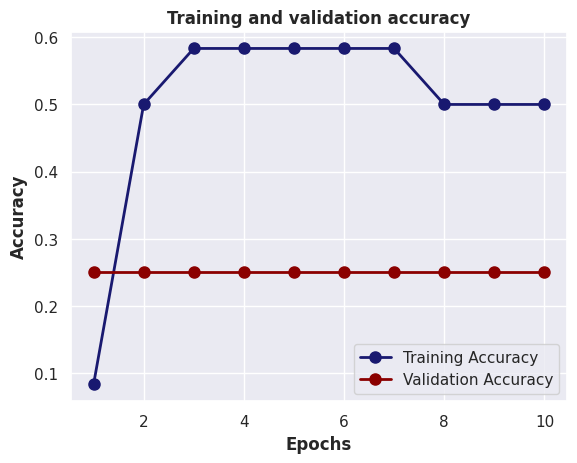

In [99]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')
                  #=========================================================
                  ############### Epochs vs Validation Accuracy Plot ##########
                  #==========================================================

plt.plot(epochs, acc, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training Accuracy','Validation Accuracy'])

In [100]:
model = load_model(path+'Document_Test.h5')

In [101]:
class_names = ['entertainment','international' ,'opinion' ,'politics','sports','business','literature',  'religion','tech']
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'entertainment','1':'international','2':'opinion','3':'politics','4':'sports','5':'business',
                              '6': 'literature','7':'religion','8':'tech'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
sports,50.0,100.0,66.67,1.0
business,0.0,0.0,0.00,1.0
accuracy,50.0,50.0,50.00,0.5
macro avg,25.0,50.0,33.33,2.0
weighted avg,25.0,50.0,33.33,2.0


In [114]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred) 

class_names = ['entertainment','international' ,'opinion' ,'politics','sports','business','literature',  'religion','tech']
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens", fmt='g')
plt.title('CNN-BiLSTM \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

1/1 [==============================] - 0s 49ms/step


ValueError: ignored

In [112]:
sample_news = '‘সোনার বাংলা সার্কাস’। একটি দুটি নয়, পাঁচটি ভিন্ন ভিন্ন মঞ্চে গাইবে তারা। কনসার্টের মৌসুমে দেশের বিভিন্ন স্থানে ব্যস্ত সময় পার করছে দলটি। এরই মধ্যে কনসার্ট করতে আজ ভারতের উদ্দেশ্যে উড়াল দিয়েছে ‘সোনার বাংলা সার্কাস’।আগামীকাল শনিবার থেকে ২৫ ফেব্রুয়ারি কলকাতায় ৫টি স্টেজ শোতে গান গাইবেন '
cleaned_news = cleaning_documents(sample_news)

class_names = ['entertainment','international' ,'opinion' ,'politics','sports','business','literature',  'religion','tech']

#print(cleaned_news)
# load the saved tokenizer
with open(path+'tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)
#print(len(loaded_tokenizer.word_index))
seq= loaded_tokenizer.texts_to_sequences([cleaned_news])
padded = pad_sequences(seq, value=0.0,padding='post', maxlen= 300 )
pred = model.predict(padded)
#print(pred) 
class_names[np.argmax(pred)]   

1/1 [==============================] - 0s 270ms/step


'sports'

In [113]:
# print top most classes
y_pred = pred.reshape(-1)
class_labels=[(class_names[i],round(prob*100,2)) for i,prob in enumerate(y_pred) if prob > 0.1]

for k, v in class_labels:
  print(k,'====>',v,'%')

entertainment ====> 15.23 %
sports ====> 69.26 %
